## Problem Statement



> **QUESTION**: The [Rain in Australia dataset](https://kaggle.com/jsphyg/weather-dataset-rattle-package) contains about 10 years of daily weather observations from numerous Australian weather stations.
> As a data scientist at the Bureau of Meteorology, you are tasked with creating a fully-automated system that can use today's weather data for a given location to predict whether it will rain at the location tomorrow.


**EXERCISE**: Before proceeding further, take a moment to think about how you can approach this problem. List five or more ideas that come to your mind below:

1. Do basic EDA: check missing values, class balance (how many “RainTomorrow = Yes/No”), look for obvious predictors like RainToday, Humidity, Cloud, Pressure.
2. Build a simple baseline model: predict “No” for everyone (or always use today’s rain → tomorrow’s rain), to have something to beat.
3. Create features from today’s weather: e.g. Humidity3pm, RainToday, Temp3pm, WindGustSpeed, Pressure3pm — and train a classification model (Logistic Regression / RandomForest) to predict RainTomorrow.
4. Handle missing data properly: impute numeric cols (median/mean), fill/categorize missing categorical values, maybe drop columns with too many NaNs.
5. Encode categorical columns (Location, WindDir9am, WindDir3pm, WindGustDir) using one-hot encoding.
6. Split into train/test by **date** (older → train, newer → test) to simulate real forecasting.
7. Evaluate with accuracy **and** recall/precision for the “RainTomorrow = Yes” class (it’s usually imbalanced).

## Linear Regression vs. Logistic Regression

When predicting **continuous values** (like medical charges), we use **Linear Regression**.
When predicting **categories or classes** (like rain vs no rain), we use **Logistic Regression**.

---

| Aspect | Linear Regression | Logistic Regression |
|:--------|:------------------|:--------------------|
| **Goal** | Predict a continuous **numeric value** | Predict a **category/class** (e.g., Rain/No Rain) |
| **Output** | Any real number (−∞ to +∞) | A probability between 0 and 1 |
| **Typical Use** | Price, temperature, salary, medical costs | Spam detection, disease diagnosis, rainfall prediction |
| **Decision Boundary** | Continuous value, no threshold | Converts probability to class label using threshold (e.g., 0.5) |
| **Loss Function** | Mean Squared Error (MSE) | Binary Cross-Entropy (Log Loss) |
| **Assumption** | Linear relationship between X and y | Classes are separable in feature space |
| **Interpretation** | Predicts *how much* | Predicts *which class* |

---

### Mathematical Form

**Linear Regression:**

$$
\hat{y} = w^T x + b
$$

**Logistic Regression:**

$$
\hat{p} = \sigma(w^T x + b)
$$

where the **sigmoid (logistic)** function is:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

This ensures that the output probability \( \hat{p} \) always lies between **0 and 1**.

---

### Summary

- **Linear Regression** → Best for predicting continuous outcomes
- **Logistic Regression** → Best for predicting binary (yes/no) or categorical outcomes



## Downloading the Data


In [ ]:
import pandas as pd

df = pd.read_csv("weatherAUS.csv")
df.head()

The dataset contains over 145,000 rows and 23 columns. The dataset contains date, numeric and categorical columns. Our objective is to create a model to predict the value in the column `RainTomorrow`.

Let's check the data types and missing values in the various columns.

In [ ]:
df.info()

In [ ]:
df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

## Exploratory Data Analysis and Visualization

Before training a machine learning model, its always a good idea to explore the distributions of various columns and see how they are related to the target column. Let's explore and visualize the data using the Plotly, Matplotlib and Seaborn libraries.

In [ ]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [ ]:
px.histogram(df, x='Location', title='Location vs. Rainy Days', color='RainToday')

In [ ]:
px.histogram(df,
             x='Temp3pm',
             title='Temp at 3pm vs. Rainy Days',
             color='RainTomorrow')

In [ ]:
px.histogram(df,
             x='RainTomorrow',
             color='RainToday',
             title='Rain Tomorrow vs. Rain Today')

In [ ]:
px.scatter(df.sample(2000),
           title='Min Temp. vs Max Temp.',
           x='MinTemp',
           y='MaxTemp',
           color='RainToday')

In [ ]:
px.scatter(df.sample(2000),
           title='Temp at 3 pm vs. Humidity (3 pm)',
           x='Temp3pm',
           y='Humidity3pm',
           color='RainTomorrow')

> **EXERCISE**: Visualize all the other columns of the dataset and study their relationship with the `RainToday` and `RainTomorrow` columns.

In [ ]:
# --- NUMERIC FEATURES ---
from plotly.subplots import make_subplots

num_features = [
    'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
    'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
    'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
    'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm'
]

# Create small box plots for numeric columns vs RainTomorrow
for col in num_features:
    fig = px.box(
        df, x='RainTomorrow', y=col, color='RainTomorrow',
        title=f"{col} vs RainTomorrow", height=300, width=400
    )
    fig.update_layout(showlegend=False)
    fig.show()

# --- CATEGORICAL FEATURES ---
cat_features = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

for col in cat_features:
    fig = px.histogram(
        df, x=col, color='RainTomorrow', barmode='group',
        title=f"{col} distribution by RainTomorrow", height=300, width=500
    )
    fig.update_xaxes(categoryorder='total descending')
    fig.update_layout(showlegend=True)
    fig.show()

# --- OPTIONAL COMPACT GRID FOR KEY FEATURES ---
fig = make_subplots(rows=2, cols=2, subplot_titles=[
    "Humidity3pm vs RainTomorrow",
    "Pressure3pm vs RainTomorrow",
    "WindSpeed3pm vs RainTomorrow",
    "Temp3pm vs RainTomorrow"
])

features = ['Humidity3pm', 'Pressure3pm', 'WindSpeed3pm', 'Temp3pm']
r, c = 1, 1

for f in features:
    box = px.box(df, x='RainTomorrow', y=f, color='RainTomorrow')
    for trace in box.data:
        fig.add_trace(trace, row=r, col=c)
    c += 1
    if c == 3:
        c = 1
        r += 1

fig.update_layout(height=700, width=850, title_text="Key Weather Features vs RainTomorrow", showlegend=False)
fig.show()


In [55]:
use_sample = False

sample_fraction = 0.1

if use_sample:
    df = df.sample(frac=sample_fraction).copy()

## Training, Validation and Test Sets

While building real-world machine learning models, it is quite common to split the dataset into three parts:

1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using an optimization technique.


2. **Validation set** - used to evaluate the model during training, tune model hyperparameters (optimization technique, regularization etc.), and pick the best version of the model. Picking a good validation set is essential for training models that generalize well.

3. **Test set** - used to compare different models or approaches and report the model's final accuracy. For many datasets, test sets are provided separately. The test set should reflect the kind of data the model will encounter in the real-world, as closely as feasible.


As a general rule of thumb you can use around 60% of the data for the training set, 20% for the validation set and 20% for the test set. If a separate test set is already provided, you can use a 75%-25% training-validation split.


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

In [ ]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

In [ ]:
plt.title('No. of Rows per Year')
sns.countplot(x=pd.to_datetime(df.Date).dt.year);

In [ ]:
year = pd.to_datetime(df.Date).dt.year

train_df = df[year < 2015]
val_df = df[year == 2015]
test_df = df[year > 2015]

In [ ]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

## Identifying Input and Target Columns

Often, not all the columns in a dataset are useful for training a model. In the current dataset, we can ignore the `Date` column, since we only want to weather conditions to make a prediction about whether it will rain the next day.

Let's create a list of input columns, and also identify the target column.

In [ ]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'
print(input_cols)

We can now create inputs and targets for the training, validation and test sets for further processing and model training.

In [ ]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

Let's also identify which of the columns are numerical and which ones are categorical. This will be useful later, as we'll need to convert the categorical data to numbers for training a logistic regression model.

In [ ]:
import numpy as np

numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [ ]:
train_inputs[numeric_cols].describe()

In [ ]:
train_inputs[categorical_cols].nunique()

## Imputing Missing Numeric Data

Machine learning models can't work with missing numerical data. The process of filling missing values is called imputation.


There are several techniques for imputation, but we'll use the most basic one: replacing missing values with the average value in the column using the `SimpleImputer` class from `sklearn.impute`.

In [23]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

In [24]:
df[numeric_cols].isna().sum()

MinTemp            468
MaxTemp            307
Rainfall             0
Evaporation      59694
Sunshine         66805
WindGustSpeed     9105
WindSpeed9am      1055
WindSpeed3pm      2531
Humidity9am       1517
Humidity3pm       3501
Pressure9am      13743
Pressure3pm      13769
Cloud9am         52625
Cloud3pm         56094
Temp9am            656
Temp3pm           2624
dtype: int64

In [25]:
imputer.fit(df[numeric_cols])

,missing_values,nan
,strategy,'mean'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [26]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [27]:
train_inputs[numeric_cols].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

## Scaling Numeric Features

Another good practice is to scale numeric features to a small range of values e.g. $(0,1)$ or $(-1,1)$. Scaling numeric features ensures that no particular feature has a disproportionate impact on the model's loss. Optimization algorithms also work better in practice with smaller numbers.

The numeric columns in our dataset have varying ranges.

In [28]:
df[numeric_cols].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,140319.000000,140480.00000,140787.000000,81093.000000,73982.000000,131682.000000,139732.000000,138256.000000,139270.000000,137286.000000,127044.000000,127018.000000,88162.000000,84693.000000,140131.000000,138163.000000
mean,12.184824,23.23512,2.349974,5.472516,7.630540,39.970520,13.990496,18.631141,68.826833,51.449288,1017.654577,1015.257963,4.431161,4.499250,16.987066,21.693183
std,6.403879,7.11450,8.465173,4.189132,3.781729,13.578201,8.886210,8.798096,19.063650,20.807310,7.104867,7.035411,2.886594,2.719752,6.496012,6.937784
min,-8.500000,-4.80000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.90000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.000000,1010.400000,1.000000,2.000000,12.300000,16.600000
50%,12.000000,22.60000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.30000,0.800000,7.400000,10.700000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,33.900000,48.10000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


In [30]:
from sklearn.preprocessing import MinMaxScaler

First, we `fit` the scaler to the data i.e. compute the range of values for each numeric column.

In [31]:
scaler = MinMaxScaler()

scaler.fit(df[numeric_cols])

,feature_range,"(0, ...)"
,copy,True
,clip,False


We can now separately scale the training, validation and test sets using the `transform` method of `scaler`.

In [32]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

We can now verify that values in each column lie in the range $(0,1)$

In [33]:
train_inputs[numeric_cols].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000
mean,0.483689,0.525947,0.006396,0.036949,0.525366,0.265107,0.108395,0.215668,0.686309,0.514693,0.612014,0.608705,0.483192,0.493693,0.507089,0.517103
std,0.149458,0.131904,0.022962,0.021628,0.200931,0.102420,0.068800,0.101424,0.189008,0.206376,0.111335,0.106611,0.255486,0.238028,0.134722,0.130726
min,0.000000,0.013233,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030400,0.000000,0.000000,0.027426,0.005758
25%,0.377358,0.429112,0.000000,0.026207,0.517241,0.193798,0.053846,0.149425,0.570000,0.370000,0.543802,0.540800,0.333333,0.333333,0.409283,0.422265
50%,0.478774,0.514178,0.000000,0.037741,0.526244,0.255814,0.100000,0.218391,0.690000,0.520000,0.614125,0.610527,0.492351,0.499917,0.502110,0.506718
75%,0.591981,0.618147,0.002156,0.038621,0.634483,0.310078,0.146154,0.275862,0.830000,0.650000,0.682645,0.675200,0.666667,0.666667,0.601266,0.604607
max,1.000000,1.000000,1.000000,0.568276,0.986207,1.000000,0.669231,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.988484


## Encoding Categorical Data

Since machine learning models can only be trained with numeric data, we need to convert categorical data to numbers. A common technique is to use one-hot encoding for categorical columns.

One hot encoding involves adding a new binary (0/1) column for each unique category of a categorical column.

In [34]:
df[categorical_cols].nunique()

Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

In [38]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')

encoder.fit(df[categorical_cols])

,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [40]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [41]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

C:\Users\user\AppData\Local\Temp\ipykernel_30440\3778302136.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\user\AppData\Local\Temp\ipykernel_30440\3778302136.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\user\AppData\Local\Temp\ipykernel_30440\3778302136.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fra

In [42]:
pd.set_option('display.max_columns', None)

In [43]:
test_inputs

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_nan,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_nan,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes
2498,Albury,0.681604,0.801512,0.000000,0.037741,0.526244,ENE,0.372093,NaN,ESE,0.000000,0.080460,0.46,0.17,0.543802,0.5136,0.777778,0.333333,0.702532,0.808061,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2499,Albury,0.693396,0.725898,0.001078,0.037741,0.526244,SSE,0.341085,SSE,SE,0.069231,0.195402,0.54,0.30,0.505785,0.5008,0.888889,0.888889,0.675105,0.712092,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2500,Albury,0.634434,0.527410,0.005930,0.037741,0.526244,ENE,0.325581,ESE,ENE,0.084615,0.448276,0.62,0.67,0.553719,0.6032,0.888889,0.888889,0.611814,0.477927,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2501,Albury,0.608491,0.538752,0.042049,0.037741,0.526244,SSE,0.255814,SE,SSE,0.069231,0.195402,0.74,0.65,0.618182,0.6304,0.888889,0.888889,0.556962,0.518234,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

## Saving Processed Data to Disk

It can be useful to save processed data to disk, especially for really large datasets, to avoid repeating the preprocessing steps every time you start the Jupyter notebook. The parquet format is a fast and efficient format for saving and loading Pandas dataframes.

In [44]:
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')
test_inputs.to_parquet('test_inputs.parquet')

In [45]:
%%time
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')
pd.DataFrame(test_targets).to_parquet('test_targets.parquet')

CPU times: total: 31.2 ms
Wall time: 38.8 ms


## Training a Logistic Regression Model

In [46]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear')

`model.fit` uses the following workflow for training the model

1. We initialize a model with random parameters (weights & biases).
2. We pass some inputs into the model to obtain predictions.
3. We compare the model's predictions with the actual targets using the loss function.
4. We use an optimization technique (like least squares, gradient descent etc.) to reduce the loss by adjusting the weights & biases of the model
5. We repeat steps 1 to 4 till the predictions from the model are good enough.


In [47]:
model.fit(train_inputs[numeric_cols + encoded_cols], train_targets)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


## Making Predictions and Evaluating the Model

We can now use the trained model to make predictions on the training, test

In [49]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [50]:
train_preds = model.predict(X_train)

In [51]:
train_probs = model.predict_proba(X_train)

In [54]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [53]:
accuracy_score(train_targets, train_preds)

0.8519206433440829

In [56]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

Accuracy: 85.19%


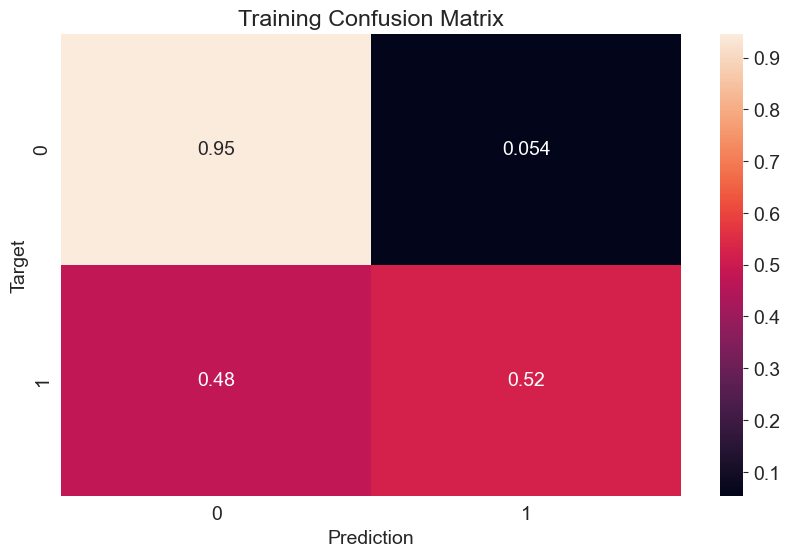

In [57]:
train_preds = predict_and_plot(X_train, train_targets, 'Training')

Let's compute the model's accuracy on the validation and test sets too.

Accuracy: 85.40%


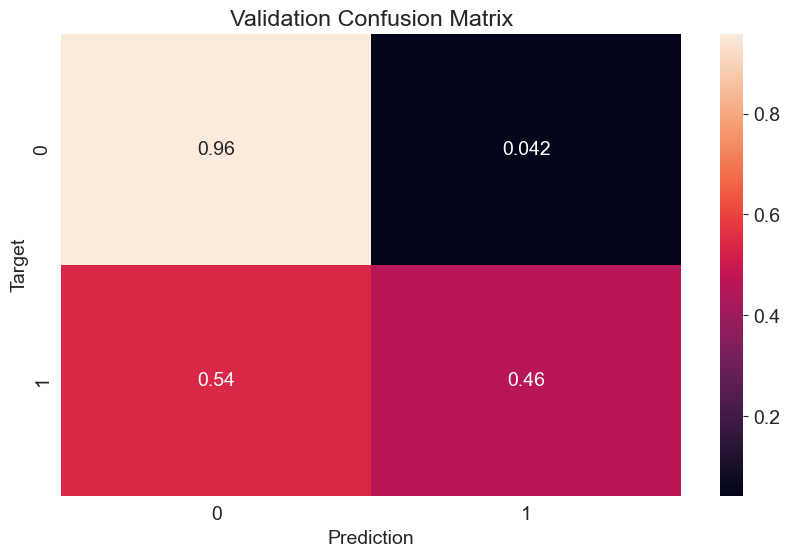

In [58]:
val_preds = predict_and_plot(X_val, val_targets, 'Validation')

Accuracy: 84.20%


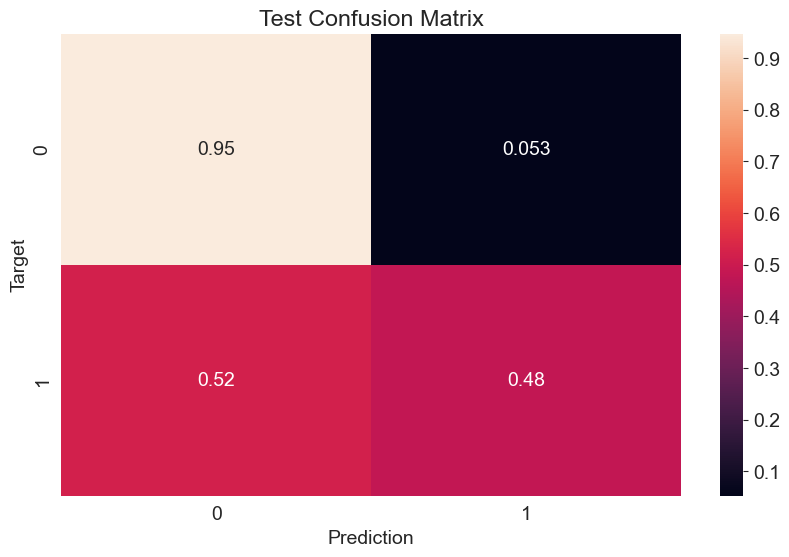

In [59]:
test_preds = predict_and_plot(X_test, test_targets, 'Test')

The accuracy of the model on the test and validation set are above 84%, which suggests that our model generalizes well to data it hasn't seen before.

But how good is 84% accuracy? While this depends on the nature of the problem and on business requirements, a good way to verify whether a model has actually learned something useful is to compare its results to a "random" or "dumb" model.

Let's create two models: one that guesses randomly and another that always return "No". Both of these models completely ignore the inputs given to them.

In [60]:
def random_guess(inputs):
    return np.random.choice(["No", "Yes"], len(inputs))

def all_no(inputs):
    return np.full(len(inputs), "No")

In [61]:
accuracy_score(test_targets, random_guess(X_test))

0.49649941656942825

In [62]:
accuracy_score(test_targets, all_no(X_test))

0.7734344612991054

Our random model achieves an accuracy of 50% and our "always No" model achieves an accuracy of 77%.

Thankfully, our model is better than a "dumb" or "random" model! This is not always the case, so it's a good practice to benchmark any model you train against such baseline models.

> **EXERCISE**: Initialize the `LogisticRegression` model with different arguments and try to achieve a higher accuracy. The arguments used for initializing the model are called hyperparameters (to differentiate them from weights and biases - parameters that are learned by the model during training).

baseline liblinear -> Accuracy: 85.40%


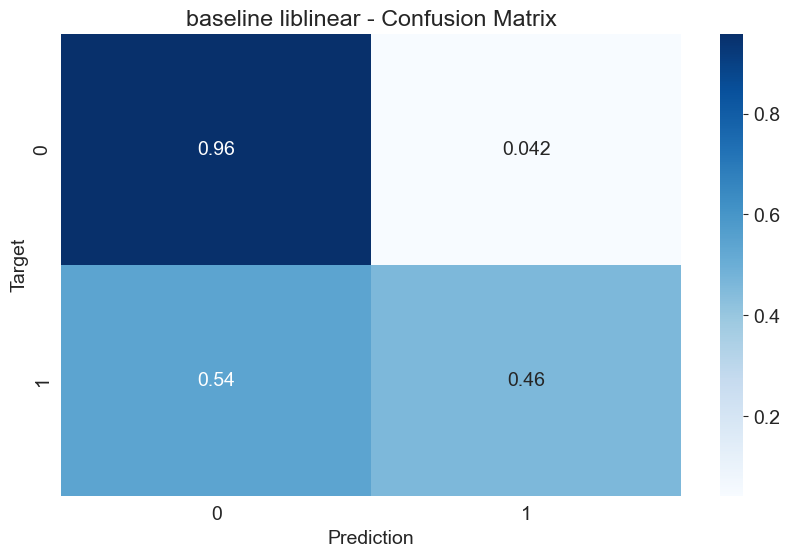

C=0.5 -> Accuracy: 85.38%


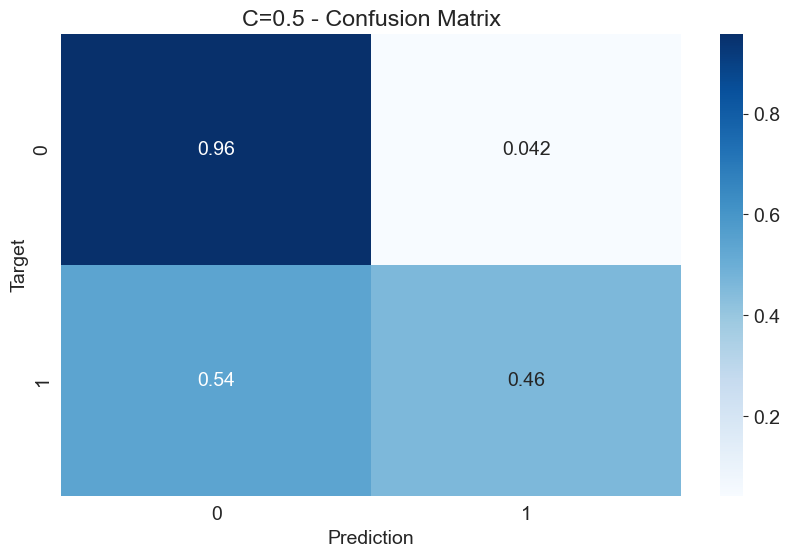

C=0.1 -> Accuracy: 85.32%


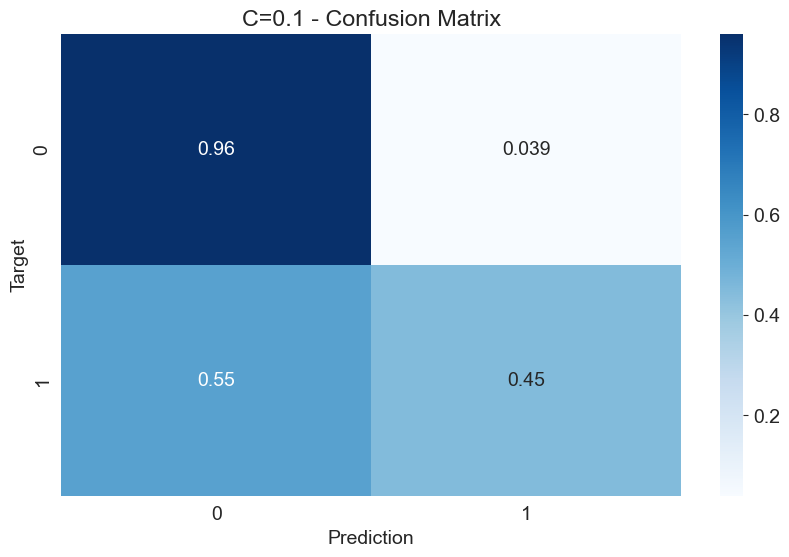

C=2.0 -> Accuracy: 85.44%


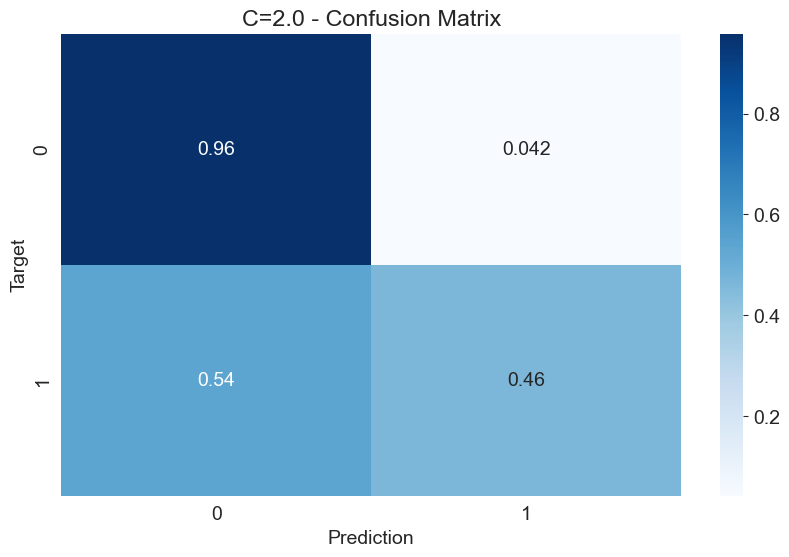

C=5.0 -> Accuracy: 85.40%


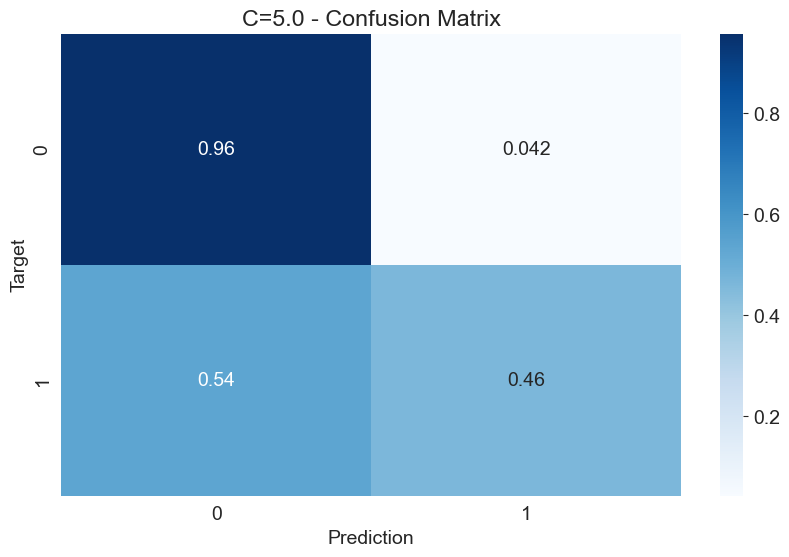

class_weight=balanced -> Accuracy: 81.43%


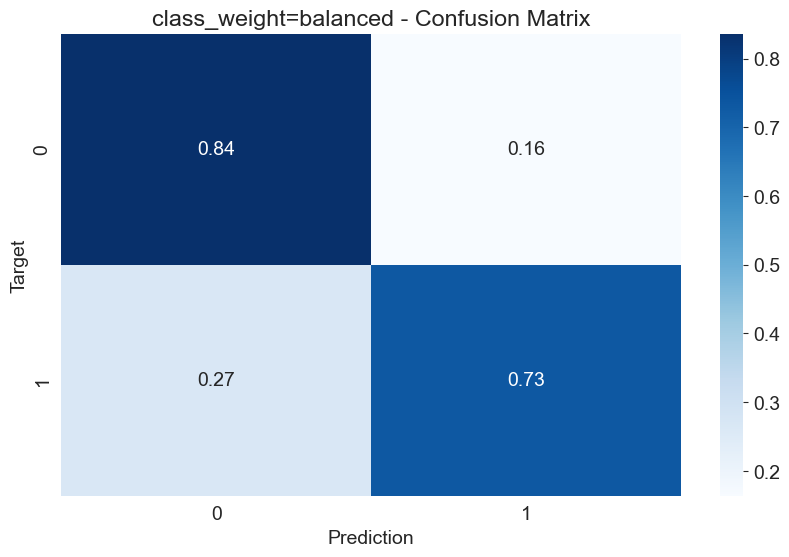

lbfgs max_iter=1000 -> Accuracy: 85.36%


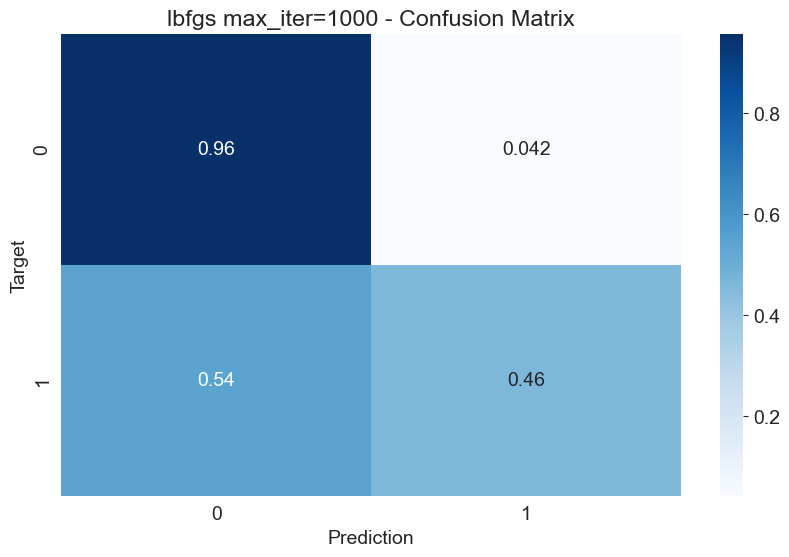

0.8536485458482065

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X_train = train_inputs[numeric_cols + encoded_cols]
X_val   = val_inputs[numeric_cols + encoded_cols]
y_train = train_targets
y_val   = val_targets  # make sure you have this

def evaluate_model(model, name=""):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print(f"{name} -> Accuracy: {acc*100:.2f}%")

    cf = confusion_matrix(y_val, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True, cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Prediction")
    plt.ylabel("Target")
    plt.show()
    return acc

# 1) baseline
evaluate_model(LogisticRegression(solver="liblinear"), "baseline liblinear")

# 2) stronger regularization (C smaller -> more regularization)
evaluate_model(LogisticRegression(solver="liblinear", C=0.5), "C=0.5")
evaluate_model(LogisticRegression(solver="liblinear", C=0.1), "C=0.1")

# 3) weaker regularization (C bigger -> model can fit more)
evaluate_model(LogisticRegression(solver="liblinear", C=2.0), "C=2.0")
evaluate_model(LogisticRegression(solver="liblinear", C=5.0), "C=5.0")

# 4) handle class imbalance (rain/no rain is often imbalanced)
evaluate_model(LogisticRegression(solver="liblinear", class_weight="balanced"), "class_weight=balanced")

# 5) try another solver that handles more features
evaluate_model(LogisticRegression(solver="lbfgs", max_iter=1000), "lbfgs max_iter=1000")


### 🔍 Hyperparameter Tuning Results

I experimented with several **Logistic Regression hyperparameters**, such as:

- **`C`** (regularization strength) — controls how much the model is penalized for complex weights
- **`solver`** — the algorithm used to optimize the weights
- **`class_weight='balanced'`** — compensates for class imbalance
- **`max_iter`** — increases the number of optimization steps if the model doesn’t converge


> **EXERCISE**: Train a logistic regression model using just the numeric columns from the dataset. Does it perform better or worse than the model trained above?

Accuracy (numeric only): 84.60%


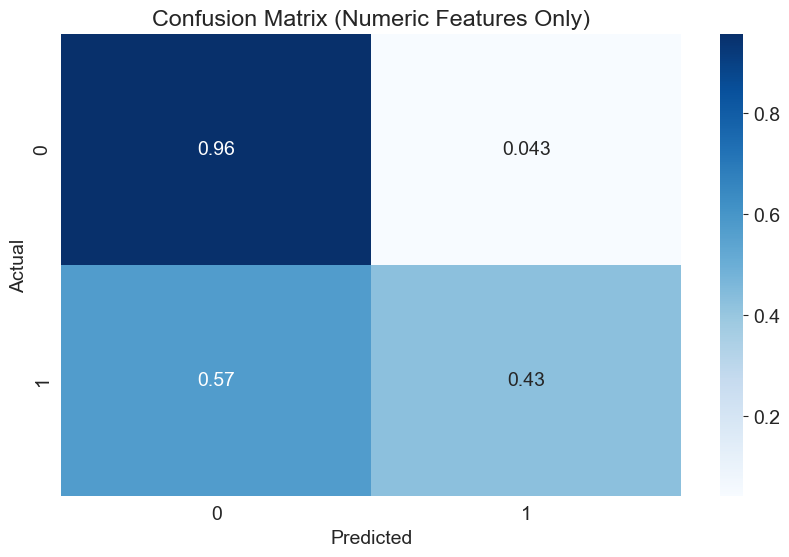

In [64]:
# Use only numeric columns
X_train_num = train_inputs[numeric_cols]
X_val_num   = val_inputs[numeric_cols]
y_train     = train_targets
y_val       = val_targets

# Train model
model_num = LogisticRegression(solver='liblinear')
model_num.fit(X_train_num, y_train)

# Evaluate model
preds_num = model_num.predict(X_val_num)
acc_num = accuracy_score(y_val, preds_num)
print(f"Accuracy (numeric only): {acc_num*100:.2f}%")

# Plot confusion matrix
cf_num = confusion_matrix(y_val, preds_num, normalize='true')
sns.heatmap(cf_num, annot=True, cmap='Blues')
plt.title("Confusion Matrix (Numeric Features Only)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

> **EXERCISE**: Train a logistic regression model using just the categorical columns from the dataset. Does it perform better or worse than the model trained above?

Accuracy (categorical only): 79.55%


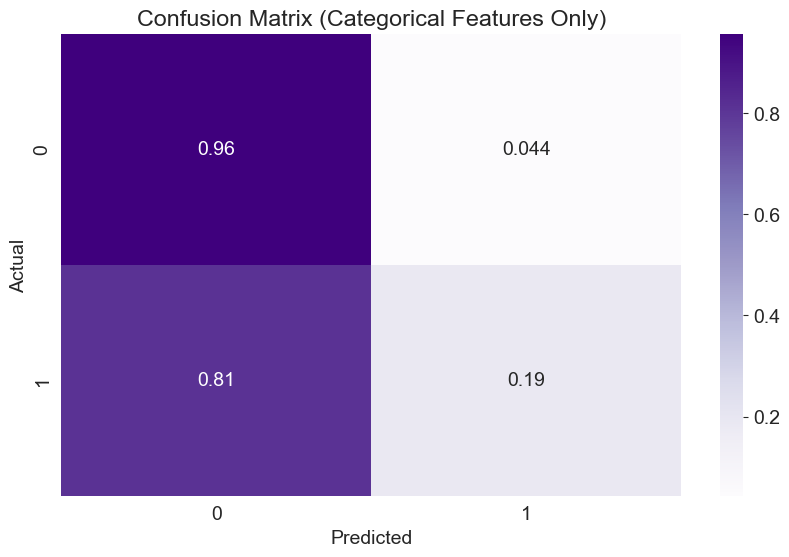

In [65]:

# Use only the encoded categorical columns
X_train_cat = train_inputs[encoded_cols]
X_val_cat   = val_inputs[encoded_cols]
y_train     = train_targets
y_val       = val_targets

# Train model
model_cat = LogisticRegression(solver='liblinear', max_iter=500)
model_cat.fit(X_train_cat, y_train)

# Evaluate model
preds_cat = model_cat.predict(X_val_cat)
acc_cat = accuracy_score(y_val, preds_cat)
print(f"Accuracy (categorical only): {acc_cat*100:.2f}%")

# Plot confusion matrix
cf_cat = confusion_matrix(y_val, preds_cat, normalize='true')
sns.heatmap(cf_cat, annot=True, cmap='Purples')
plt.title("Confusion Matrix (Categorical Features Only)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

> **EXERCISE**: Train a logistic regression model without feature scaling. Also try a different strategy for missing data imputation. Does it perform better or worse than the model trained above?

Accuracy (no scaling, most_frequent imputation): 85.40%


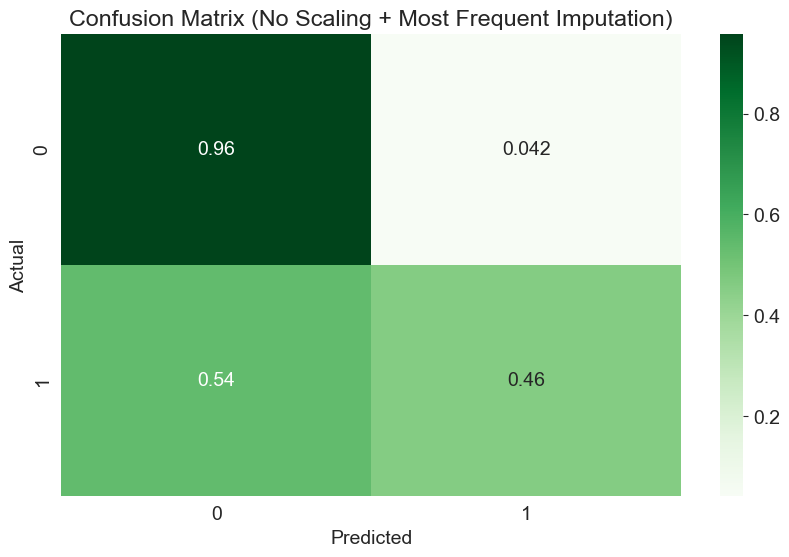

In [66]:

# --- 1️⃣ Handle Missing Data (different strategy) ---
# Instead of using mean/median, let's try 'most_frequent' for both numeric & categorical

num_imputer = SimpleImputer(strategy='most_frequent')
cat_imputer = SimpleImputer(strategy='most_frequent')

train_num = pd.DataFrame(num_imputer.fit_transform(train_inputs[numeric_cols]), columns=numeric_cols, index=train_inputs.index)
val_num   = pd.DataFrame(num_imputer.transform(val_inputs[numeric_cols]), columns=numeric_cols, index=val_inputs.index)

train_cat = pd.DataFrame(cat_imputer.fit_transform(train_inputs[encoded_cols]), columns=encoded_cols, index=train_inputs.index)
val_cat   = pd.DataFrame(cat_imputer.transform(val_inputs[encoded_cols]), columns=encoded_cols, index=val_inputs.index)

# Combine again (no scaling applied!)
X_train_noscale = pd.concat([train_num, train_cat], axis=1)
X_val_noscale   = pd.concat([val_num, val_cat], axis=1)

y_train = train_targets
y_val   = val_targets

# --- 2️⃣ Train Logistic Regression (without feature scaling) ---
model_noscale = LogisticRegression(solver='liblinear', max_iter=500)
model_noscale.fit(X_train_noscale, y_train)

# --- 3️⃣ Evaluate Model ---
preds_noscale = model_noscale.predict(X_val_noscale)
acc_noscale = accuracy_score(y_val, preds_noscale)
print(f"Accuracy (no scaling, most_frequent imputation): {acc_noscale*100:.2f}%")

# Plot confusion matrix
cf_noscale = confusion_matrix(y_val, preds_noscale, normalize='true')
sns.heatmap(cf_noscale, annot=True, cmap='Greens')
plt.title("Confusion Matrix (No Scaling + Most Frequent Imputation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Making Predictions on a Single Input

Once the model has been trained to a satisfactory accuracy, it can be used to make predictions on new data. Consider the following dictionary containing data collected from the Katherine weather department today.

In [69]:
new_input = {'Date': '2021-06-19',
             'Location': 'Katherine',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

new_input_df = pd.DataFrame([new_input])
new_input_df[numeric_cols] = imputer.transform(new_input_df[numeric_cols])
new_input_df[numeric_cols] = scaler.transform(new_input_df[numeric_cols])
new_input_df[encoded_cols] = encoder.transform(new_input_df[categorical_cols])

X_new_input = new_input_df[numeric_cols + encoded_cols]

prediction = model.predict(X_new_input)[0]

C:\Users\user\AppData\Local\Temp\ipykernel_30440\4048219494.py:27: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\user\AppData\Local\Temp\ipykernel_30440\4048219494.py:27: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\user\AppData\Local\Temp\ipykernel_30440\4048219494.py:27: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

In [68]:
prediction

'Yes'

The first step is to convert the dictionary into a Pandas dataframe, similar to `raw_df`. This can be done by passing a list containing the given dictionary to the `pd.DataFrame` constructor.
We've now created a Pandas dataframe with the same columns as `raw_df` (except `RainTomorrow`, which needs to be predicted). The dataframe contains just one row of data, containing the given input.

We must now apply the same transformations applied while training the model:

1. Imputation of missing values using the `imputer` created earlier
2. Scaling numerical features using the `scaler` created earlier
3. Encoding categorical features using the `encoder` created earlier

In [71]:
def predict_input(single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

In [74]:
new_input = {'Date': '2021-06-19',
             'Location': 'Launceston',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

In [75]:
predict_input(new_input)

C:\Users\user\AppData\Local\Temp\ipykernel_30440\1109115037.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\user\AppData\Local\Temp\ipykernel_30440\1109115037.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\user\AppData\Local\Temp\ipykernel_30440\1109115037.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fra

('Yes', np.float64(0.6474903379010891))

## Saving and Loading Trained Models

We can save the parameters (weights and biases) of our trained model to disk, so that we needn't retrain the model from scratch each time we wish to use it. Along with the model, it's also important to save imputers, scalers, encoders and even column names. Anything that will be required while generating predictions using the model should be saved.

We can use the `joblib` module to save and load Python objects on the disk.

In [76]:
import joblib

In [78]:
aussie_rain = {
    'model': model,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [79]:
joblib.dump(aussie_rain, 'aussie_rain.joblib')

['aussie_rain.joblib']

In [80]:
aussie_rain2 = joblib.load('aussie_rain.joblib')

Now we can use the loaded models to make predictions on the original test set

In [81]:
test_preds2 = aussie_rain2['model'].predict(X_test)
accuracy_score(test_targets, test_preds2)

0.8420070011668611